In [ ]:
import os
tf.config.list_physical_devices('GPU')
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,InputLayer
from tensorflow.keras.models import Sequential
from collections import deque
from tensorflow.keras.optimizers import Adam

import time

In [ ]:
env = gym.make("CartPole-v0")
actions = env.action_space.n
states = env.observation_space.shape[0]

In [61]:
# Parameters
#Take samples because consecutive samples of experience as they occured sequential in the environement,
#the samples would be highly correlated and lead to insufficient learning
REPLAY_MEMORY_SIZE = 50_00
MIN_REPLAY_MEMORY_SIZE = 1_00
GAMMA = 0.97
MINIBATCH_SIZE = 64

#Exploration settings
epsilon = 1
EPSILON_DECAY = 0.99
MIN_EPSILON = 0.01

In [ ]:
#Create model
class DQNAgent():
    def __init__(self):
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        
        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        
        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0
        
    def create_model(self):
        model = Sequential()
        model.add(Dense(12, input_shape=(2,), activation="relu"))
        model.add(Dense(12, activation="relu"))
        model.add(Dense(actions, activation="linear"))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])

        return model
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
    
    def get_qs(self, state):
        return self.model.predict(state)
    
    def train(self, episode):
        #Sample random batch from replay memory
        if len(self.replay_memory) >= MIN_REPLAY_MEMORY_SIZE:
            minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        else:
            return
        
        current_states = np.array([obs[0] for obs in minibatch])
        current_states = np.squeeze(current_states)
        q_list = np.array(self.model.predict(current_states))
        q_list = np.squeeze(q_list)
        
        new_current_states = np.array([obs[3] for obs in minibatch])
        new_current_states = np.squeeze(new_current_states)
        future_qs_list = np.array(self.target_model.predict(new_current_states))
        
        for i in range(MINIBATCH_SIZE):
            state = minibatch[i][0]
            action = minibatch[i][1]
            reward = minibatch[i][2]
            state_new = minibatch[i][3]
            end = minibatch[i][4]
            
        # Build Bellman equation for the Q function
            
            if end:
                q_list[i, action] = reward
            else:
                q_list[i, action] = reward + GAMMA * np.max(future_qs_list[i])
                
        # Train network to output the Q function
        current_states = tf.convert_to_tensor(current_states)
        q_list = tf.convert_to_tensor(q_list)
        self.model.fit(current_states, q_list, batch_size=MINIBATCH_SIZE, verbose=0)
        
        if episode%5==0:
            self.target_model.set_weights(self.model.get_weights())

In [62]:
#Main model
agent = DQNAgent()
n_episodes = 200
all_scores = []
start_time = time.time()
for n in range(n_episodes):
    episode_time = time.time()
    
    obs, done = env.reset(), False
    current_state = tf.convert_to_tensor(np.array([obs[2],obs[3]]).reshape(1,2))
    #Reformat for model
    
    score = 0
    step = 0
    while done == False:
        step+=1
        #Exploration/Exploitation for action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(agent.get_qs(current_state))
        
        #Execute selected action and get observation
        obs, reward, done, _ = env.step(action)
        
        if done and step != env._max_episode_steps:
            reward = -100

        #Reformat for model
        new_state = tf.convert_to_tensor(np.array([obs[2],obs[3]]).reshape(1,2))
        
        #Store experience in replay memory
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(n+1)
        
        current_state = new_state   
        score += reward
        if done:
            print(str(n+1),"{:.2f}".format(time.time()-episode_time),epsilon)
            all_scores.append(score)
         #Epsilon decay
    if epsilon > MIN_EPSILON:
        epsilon = epsilon*EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
            
    env.close()

1 0.00 1
2 0.00 0.99
3 0.00 0.9801
4 0.00 0.9702989999999999
5 1.33 0.96059601
6 0.96 0.9509900498999999
7 2.77 0.9414801494009999
8 0.92 0.9320653479069899
9 1.16 0.92274469442792
10 2.35 0.9135172474836407
11 0.99 0.9043820750088043
12 0.97 0.8953382542587163
13 4.91 0.8863848717161291
14 0.77 0.8775210229989678
15 2.25 0.8687458127689781
16 2.05 0.8600583546412883
17 1.65 0.8514577710948754
18 3.57 0.8429431933839266
19 2.33 0.8345137614500874
20 1.95 0.8261686238355865
21 2.50 0.8179069375972307
22 1.06 0.8097278682212583
23 1.06 0.8016305895390458
24 2.59 0.7936142836436553
25 3.10 0.7856781408072188
26 2.71 0.7778213593991465
27 6.26 0.7700431458051551
28 0.77 0.7623427143471035
29 1.90 0.7547192872036325
30 3.07 0.7471720943315961
31 4.08 0.7397003733882802
32 1.29 0.7323033696543974
33 1.10 0.7249803359578534
34 3.48 0.7177305325982748
35 3.08 0.7105532272722921
36 1.91 0.7034476949995692
37 3.29 0.6964132180495735
38 1.98 0.6894490858690777
39 1.23 0.682554595010387
40 5.52 0.

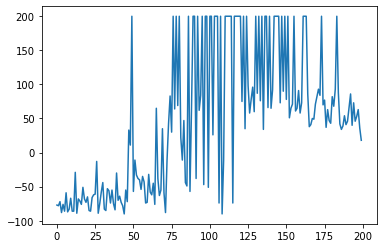

In [63]:
plt.plot(all_scores)

In [64]:
for x in range(10):
    obs, done = env.reset(), False
    current_state = np.array([obs[2],obs[3]]).reshape(1,2)
    tot_reward = 0.0
    while done == False:               
        Q = agent.get_qs(current_state)
        action = np.argmax(Q)

        obs, reward, done, info = env.step(action)
        current_state = np.array([obs[2],obs[3]]).reshape(1,2)
        tot_reward += reward
        env.render()
        
    print('Game ended! Total reward: {}'.format(tot_reward))
env.close()

Game ended! Total reward: 171.0
Game ended! Total reward: 174.0
Game ended! Total reward: 183.0
Game ended! Total reward: 166.0
Game ended! Total reward: 168.0
Game ended! Total reward: 176.0
Game ended! Total reward: 185.0
Game ended! Total reward: 165.0
Game ended! Total reward: 162.0
Game ended! Total reward: 166.0
